In [ ]:
!pip install tensorflow==2.13.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 72.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 98.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 102.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 37.9 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:
      Successfully uninstalled typing_extensions-4.12.2
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: gast
    Found existing installation: gast 0.6.0
    Uninstalling gast-0.6.0:
     

In [ ]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [ ]:
print("Versi Tensorflow yang digunakan:", tf.__version__)

Versi Tensorflow yang digunakan: 2.13.0


In [ ]:
data= pd.read_csv('cleaning.csv')
data.head(10)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
5,Female,20.0,0,0,never,27.32,6.6,85,0
6,Female,44.0,0,0,never,19.31,6.5,200,1
7,Female,79.0,0,0,No Info,23.86,5.7,85,0
8,Male,42.0,0,0,never,33.64,4.8,145,0
9,Female,32.0,0,0,never,27.32,5.0,100,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [ ]:
data.dtypes

,0
gender,object
age,float64
hypertension,int64
heart_disease,int64
smoking_history,object
bmi,float64
HbA1c_level,float64
blood_glucose_level,int64
diabetes,int64


In [ ]:
# Drop irrelevant columns
X = data.drop(['diabetes', 'heart_disease', 'smoking_history'], axis=1)
y = (data['diabetes'] > 0).astype(int)

# Encode binary columns
X['gender'] = X['gender'].map({'Male': 0, 'Female': 1})

# Scale numerical columns
numerical_cols = ['age', 'hypertension', 'bmi', 'HbA1c_level', 'blood_glucose_level']
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])


In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Define the model with more regularization and dropout
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],),kernel_regularizer=tf.keras.regularizers.l2(0.2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
# Compile the model with a learning rate scheduler
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)  # Keep the learning rate as is
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC()])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                448       
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                        

In [ ]:
# Add callbacks for early stopping and learning rate scheduling
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

In [ ]:
# Ensure proper types and dimensions
import numpy as np
X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)

# Check for and handle NaN or infinite values
X_train = np.nan_to_num(X_train)
y_train = np.nan_to_num(y_train)

# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=60,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1/60
1000/1000 [==============================] - 3s 2ms/step - loss: 0.6554 - accuracy: 0.9224 - auc: 0.8660 - val_loss: 0.1342 - val_accuracy: 0.9609 - val_auc: 0.9590 - lr: 5.0000e-04
Epoch 2/60
1000/1000 [==============================] - 3s 3ms/step - loss: 0.1412 - accuracy: 0.9572 - auc: 0.9439 - val_loss: 0.1166 - val_accuracy: 0.9630 - val_auc: 0.9627 - lr: 5.0000e-04
Epoch 3/60
1000/1000 [==============================] - 3s 3ms/step - loss: 0.1284 - accuracy: 0.9614 - auc: 0.9507 - val_loss: 0.1103 - val_accuracy: 0.9659 - val_auc: 0.9660 - lr: 5.0000e-04
Epoch 4/60
1000/1000 [==============================] - 2s 2ms/step - loss: 0.1239 - accuracy: 0.9622 - auc: 0.9532 - val_loss: 0.1069 - val_accuracy: 0.9662 - val_auc: 0.9665 - lr: 5.0000e-04
Epoch 5/60
1000/1000 [==============================] - 2s 2ms/step - loss: 0.1201 - accuracy: 0.9635 - auc: 0.9558 - val_loss: 0.1025 - val_accuracy: 0.9681 - val_auc: 0.9693 - lr: 5.0000e-04
Epoch 6/60
1000/1000 [=============

In [ ]:
X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

In [ ]:
# Evaluasi model
results = model.evaluate(X_test, y_test)

# Menampilkan hasil evaluasi
print(f"Test Accuracy: {results[1]:.2f}")
print(f"Test AUC: {results[2]:.2f}")

# Menampilkan loss dan val_loss dari history
loss = history.history['loss']
val_loss = history.history['val_loss']

print(f"Training Loss: {loss[-1]:.4f}")
print(f"Validation Loss: {val_loss[-1]:.4f}")

625/625 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.9720 - auc: 0.9757
Test Accuracy: 0.97
Test AUC: 0.98
Training Loss: 0.0959
Validation Loss: 0.0886


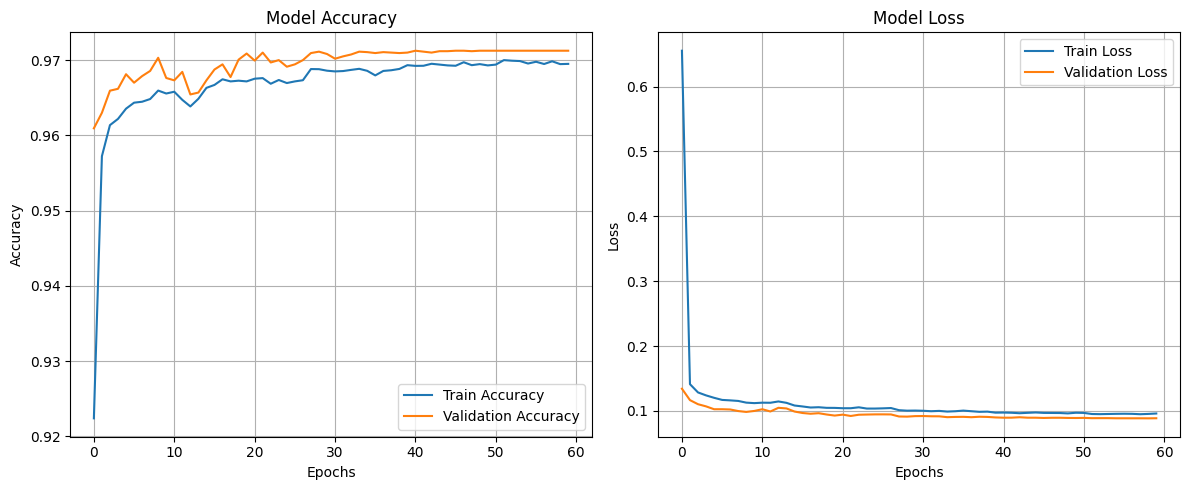

In [ ]:
# Plotting accuracy and loss
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Show plots
plt.tight_layout()
plt.show()

In [ ]:
# Save the model architecture to a JSON file
model_json = model.to_json()
with open("diabetes_mymodel.json", "w") as json_file:
    json_file.write(model_json)
print("Model architecture saved as JSON.")

# Save the model weights to an HDF5 file
model.save_weights("diabetes_mymodel.weights.h5")
print("Model weights saved separately.")

# Save the model as a Keras file (Recommended format)
model.save("diabetes_my_model.keras")
print("Model saved keras.")

# Save the model weights to an HDF5 file
model.save("diabetes_mymodel.h5")
print("Model saved H5 separately.")

Model architecture saved as JSON.
Model weights saved separately.
Model saved keras.
Model saved H5 separately.


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
